In [1]:
from sympy import *
init_printing()

In [ ]:
data_path_vandstand = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Dag.csv'
data_path_inflow = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandforing, Dognmiddel (DMP)_Dag.csv'

In [ ]:
import pandas as pd

# Fil­sti­er til daglige data
data_path_vandstand = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Dag.csv'
data_path_inflow   = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandforing, Dognmiddel (DMP)_Dag.csv'

def load_daily(path, value_name):
    # 1) Find header-rækken, der starter med "Dato (DK normaltid)"
    with open(path, encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith('Dato (DK normaltid)'):
                header_row = i
                break

    # 2) Læs kun de to kolonner: dato og værdi
    df = pd.read_csv(
        path,
        sep=';',
        skiprows=header_row,
        header=0,
        usecols=[0, 1],
        encoding='latin1',
        engine='python'
    )

    # 3) Omdøb kolonnerne til 'date' og value_name
    df.columns = ['date', value_name]

    # 4) Parse dato og sæt som indeks
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df.set_index('date', inplace=True)

    # 5) Lokaliser til dansk tid (daglige data, ingen DST-problemer)
    df.index = df.index.tz_localize('Europe/Copenhagen', ambiguous=False)

    return df

# Load vandstand og vandføring uden flags
df_vandstand = load_daily(data_path_vandstand, 'water_level')
df_inflow    = load_daily(data_path_inflow,   'water_flow')

# Merge på dato-indeks
df_daily = df_vandstand.join(df_inflow, how='inner')

# Check resultatet
print("\nPeriode fra", df_daily.index.min(), "til", df_daily.index.max())
df_daily.head()


Periode fra 1987-01-02 00:00:00+01:00 til 2021-12-31 00:00:00+01:00


,water_level,water_flow
date,,
1987-01-02 00:00:00+01:00,7.310,1966.827
1987-01-03 00:00:00+01:00,7.287,1856.732
1987-01-04 00:00:00+01:00,7.294,1867.284
1987-01-05 00:00:00+01:00,7.218,1455.646
1987-01-06 00:00:00+01:00,7.210,1394.233


Pearson correlation (2002-2024): 0.654


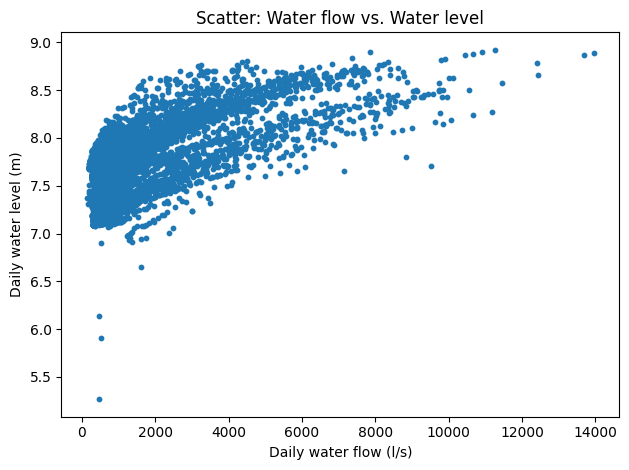

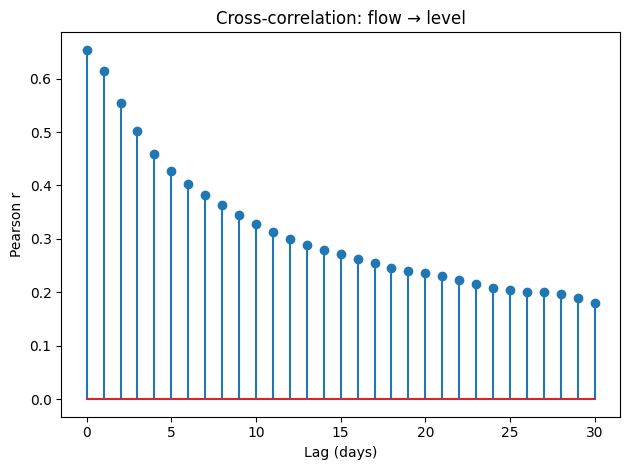


Granger‐causality p‐values:
 Lag 1: p = 0.000
 Lag 2: p = 0.000
 Lag 3: p = 0.000
 Lag 4: p = 0.000
 Lag 5: p = 0.000
 Lag 6: p = 0.000
 Lag 7: p = 0.000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# -------------------------------------------------------------------
# ASSUMPTION: df_daily is already defined with tz-localized Daily index
# -------------------------------------------------------------------

# 1) Subset 2002-01-01 to 2024-12-31
start, end = '2002-01-01', '2024-12-31'
df = df_daily.loc[start:end]

# 2) Pearson correlation
pearson_corr = df['water_level'].corr(df['water_flow'])
print(f'Pearson correlation (2002-2024): {pearson_corr:.3f}')

# 3) Scatter plot: flow vs. level
plt.figure()
plt.scatter(df['water_flow'], df['water_level'], s=10)
plt.xlabel('Daily water flow (l/s)')
plt.ylabel('Daily water level (m)')
plt.title('Scatter: Water flow vs. Water level')
plt.tight_layout()
plt.show()

# 3) Cross‐correlations for lags 0–30 days
lags = list(range(31))
lag_corrs = [df['water_level'].corr(df['water_flow'].shift(l)) for l in lags]

plt.figure()
plt.stem(lags, lag_corrs)
plt.xlabel('Lag (days)')
plt.ylabel('Pearson r')
plt.title('Cross‐correlation: flow → level')
plt.tight_layout()
plt.show()

# 4) Granger‐causality tests (lags 1–7 days)
print("\nGranger‐causality p‐values:")
gc_data = df[['water_level','water_flow']].dropna()
res = grangercausalitytests(gc_data, maxlag=7, verbose=False)
for lag in range(1,8):
    pval = res[lag][0]['ssr_ftest'][1]
    print(f" Lag {lag}: p = {pval:.3f}")